# Modeling and Evaluation

**Objective**: This notebook covers the second phase of my sales forecasting project. The goal is to build, train and evaluate a time-series model to predict sales for a stingle store-item combination. I will first establish a naive baseline to measure against, then implement a predictive model using the Prophet library, and finally, evaluate its performance and visualize the forecast.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from prophet import Prophet

# Load the data and convert the 'date' column to a format Python can understand
df = pd.read_csv('../data/train.csv', parse_dates=['date'])

### Data Preprocessing

To make the problem easier to start with, I will focus on forecasting just for a single store and a single item. Afterwards i will apply the solution to the full dataset. As such, I start by filtering the data to only include sales for Store 1, Item 1.

In [2]:
# Isolate a single time series to simplify the problem
# Starting with just Store 1, Item 1
df_s1_i1 = df[(df['store'] == 1) & (df['item'] == 1)].copy()

I am going to use a forecasting library called Prophet. This library has some specific rules: The date column must be named 'ds'; and the value we want to forecast must be names 'y'. Therefore the next step is to create a new DataFrame with just these two columns with correctly names colums.

In [3]:
# Prepare the data for Prophet
# Prophet requires the columns to be named 'ds' for date and 'y' for the value to forecast
df_prophet = df_s1_i1[['date', 'sales']].rename(columns={'date': 'ds', 'sales': 'y'})

print("Data prepared for Prophet:")
df_prophet.head()

Data prepared for Prophet:


,ds,y
0,2013-01-01,13
1,2013-01-02,11
2,2013-01-03,14
3,2013-01-04,13
4,2013-01-05,10


### Establish a Baseline Forecast

Before getting fancy, I need to set a benchmark to measure performance against. For this i will create a very simple "naive forecast". From the EDA we know that there is a strong weekly pattern. So, the naive forecast will be *"The sales for any given day will be the same as the sales on that same day last week."* To achieve this forecast we simply shift the sales data forward by seven days and remove the first seven empty values caused by the shift.


In [4]:
# Shifting the sales data by seven days to create the naive forecast
df_prophet['naive_forecast'] = df_prophet['y'].shift(7)

# Removing the first seven days because there is no data
df_prophet.dropna(inplace=True)

# Calculate the error of the naive forecast
# The Mean Absolute Error (MAE) tells us, on average, how wrong the forecast is
# For this data, an MAE of 3 means the forecast is off by an average of 3 units per day

mae_baseline = mean_absolute_error(df_prophet['y'], df_prophet['naive_forecast'])

print(f"The baseline MAE to beat is: {mae_baseline:.2f}")

The baseline MAE to beat is: 4.90


### Implement and Train the Prophet Model

To test the model's performance, I need to split the data. I'll use the majority of the data for training and reserve the last 90 days as a validation set. The model will train on the past and then try to predict the most recent 90-day period.

In [5]:
# Creating the training set
train = df_prophet[:-90]

# Create the validation set
validation = df_prophet[-90:]

Now, creating the Prophet model. Using the 'fit' method where the model learns all the underlying patterns present in the training data.

In [6]:
# Initializing the Prophet model
m = Prophet()

# Fit the model to the training data
m.fit(train)

11:09:32 - cmdstanpy - INFO - Chain [1] start processing
11:09:32 - cmdstanpy - INFO - Chain [1] done processing


With the model trained, it's now possible to make forecasts. For this I will create a DataFrame containing the future 90 days from the training period and ask the model to predict the sales for those dates, matching the validation period.

In [7]:
# Create a DataFrame that extends 90 days from into the future from the training period
future = m.make_future_dataframe(periods=90)

# Use the trained model to make a forecast
forecast = m.predict(future)

# 'yhat' is the model's prediction
# 'yhat_lower' and 'yhat_upper' represents the best and worst case
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1814,2017-12-27,16.287655,10.438200,22.225616
1815,2017-12-28,16.925322,10.838123,22.794919
1816,2017-12-29,18.744908,12.742144,24.700503
1817,2017-12-30,20.570715,14.426478,26.550984
1818,2017-12-31,21.421936,15.626213,27.299752


### Visualizing Model Performance

Now we'll compare the model's predictions to the actual sales figures from our validation set to see how well it performed. The goal is to get a Mean Absolute Error (MAE) that is lower than our baseline MAE of 4.90.

Now, on to the comparison. The goal is to get a Mean Absolute Error that is lower than the baseline MAE of 4.90.

In [8]:

# The forecast dataframe contains predictions for the entire history
# To validate, I only need the predictions for 90-day validation period

forecast_validation = forecast[-90:]

# Calculate the MAE for the Prophet model's forecast

mae_prophet = mean_absolute_error(validation['y'], forecast_validation['yhat'])

print(f"The baseline MAE was: {mae_baseline:.2f}")
print(f"The Prophet model's MAE is: {mae_prophet:.2f}")

The baseline MAE was: 4.90
The Prophet model's MAE is: 3.77


**Results**:

- Baseline MAE: 4.90
- Model MAE: 3.77

**Conclusion**:

The model, with a MAE of 3.77, outperforms the naive baseline. This confirms that the model has learned the underlying patterns in the data and providing a more accurate forecast then a simple "same day last week" guess. On average, the model's daily forecast is off by only 3.77 unites.


For evaluation it is generally easier to visually inspect the forecast. The following plot will show the actual sales data (black dots), the model's prediction (blue line), and the model's uncertainty interval (the light blue shaded areas)

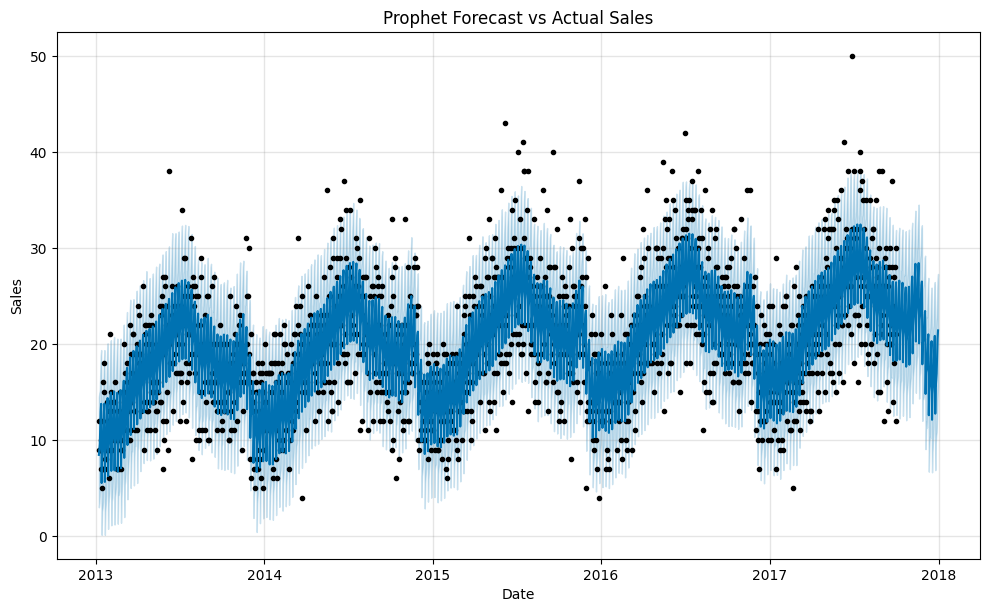

In [9]:
# Use built-ins from the Prophet library to visualize the forecast
fig1 = m.plot(forecast)
plt.title('Prophet Forecast vs Actual Sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

### Visual Forecast Analysis

The above plot visualizes the model's performance over the entire dataset.

**Key Observations**:
- The blue forecast line tracks actual sales very well
- The model has identified the long-term upward trend in sales
- The light-blue uncertainty gets slightly wider during the summer peak, correctly modeling the increased sales volatility observed during the EDA.

Finally, I will utilize Prophet's ability to show what it has learned by plotting the components of the forecast to see the patterns it learned from the data. This should look similar to the patterns identified during the EDA.

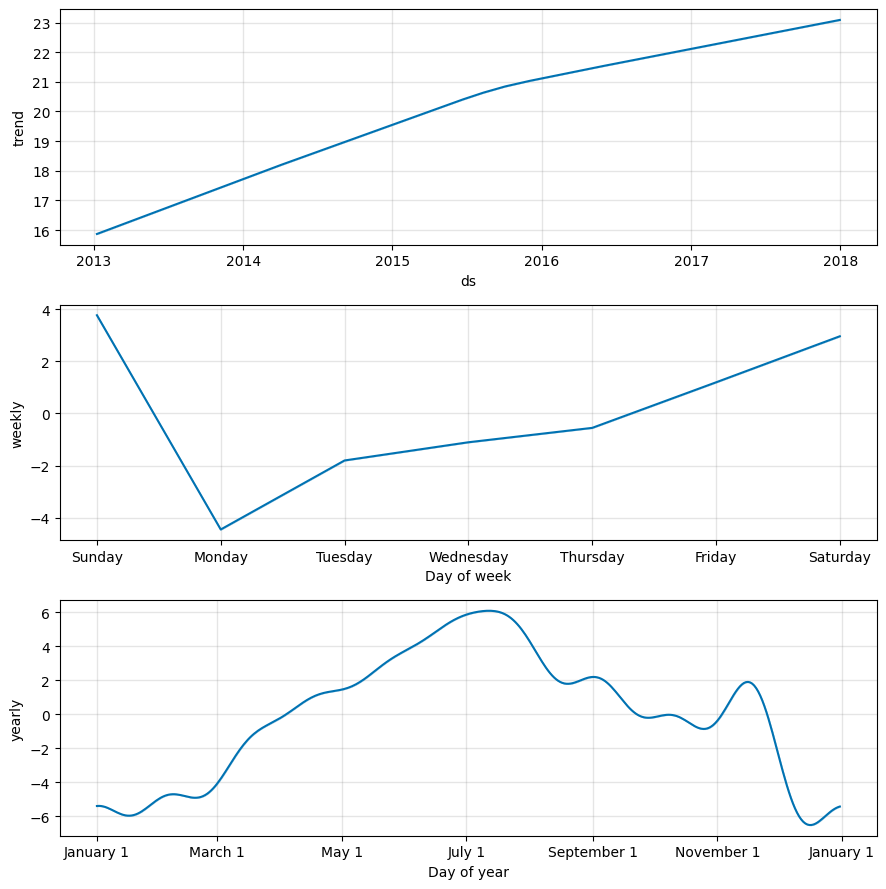

In [10]:
# Plot the individual components of the forecast
fig2 = m.plot_components(forecast)
plt.show()

### Forecast Component Analysis

These plots shows exactly what patterns the model learned.

**Conclusion:** The model has successfully identified the same three key patterns discovered manually in the EDA:

1.  **Trend:** A steady, growth over the five-year period.
2.  **Weekly Seasonality:** Sales are lowest on Monday and peak on Sunday.
3.  **Yearly Seasonality:** Sales are highest in the summer and lowest during the winter.

This confirms that the model is working as expected and its internal logic aligns with the analysis.